# Bayesian Optimization using MC dropout

In [2]:
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from mpl_toolkits.mplot3d import Axes3D

# 2-D Function

In [2]:
torch.manual_seed(23)
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y):
    return torch.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))

def mixture_gaussian_2d(x, y, x0, y0, sigma_x1, sigma_y1, sigma_x2, sigma_y2, amplitude1, amplitude2):
    gaussian1 = amplitude1 * gaussian_2d(x, y, 0, 0, sigma_x1, sigma_y1)
    gaussian2 = amplitude2 * gaussian_2d(x, y, x0, y0, sigma_x2, sigma_y2)
    return gaussian1 + gaussian2

def generate_dataset(num_samples):
    x1 = torch.linspace(-5, 5, 100)
    x2 = torch.linspace(-5, 5, 100)
    X1, X2 = torch.meshgrid(x1, x2)
    Z = mixture_gaussian_2d(X1, X2, x0, y0, sigma_x1, sigma_y1, sigma_x2, sigma_y2, amplitude1, amplitude2)
    # Sample points from the function
    indices = torch.randint(0, 10000, (num_samples,))
    X_dataset = torch.stack((X1.flatten()[indices], X2.flatten()[indices]), dim=1)
    y_dataset = Z.flatten()[indices] + torch.randn(num_samples) * 0.05  # Add noise to the function
    return X_dataset, y_dataset

# Define parameters
x0, y0 = 4, -4  # Off-center position for the second Gaussian
sigma_x1, sigma_y1 = 2, 2  # Parameters for the first Gaussian (centered at 0,0)
sigma_x2, sigma_y2 = 0.5, 0.5  # Parameters for the second Gaussian
amplitude1, amplitude2 = 2, 1  # Amplitudes for the Gaussians

# Generate the dataset
X_dataset, y_dataset = generate_dataset(100)

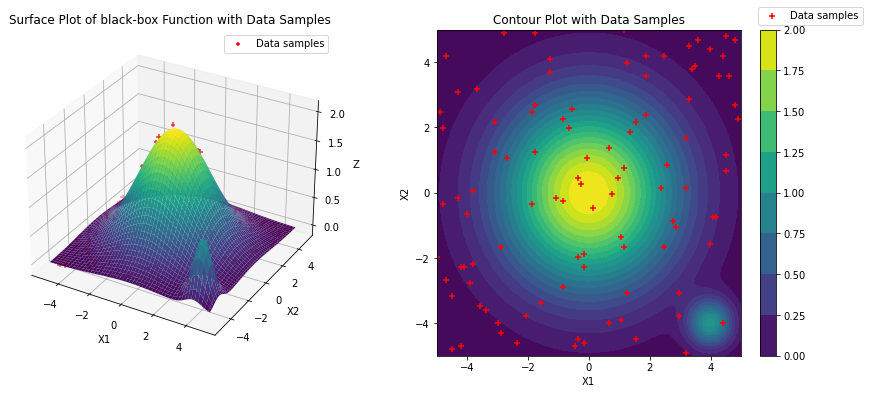

In [3]:
# Plot surface
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
x1 = torch.linspace(-5, 5, 100)
x2 = torch.linspace(-5, 5, 100)
X1, X2 = torch.meshgrid(x1, x2)
Z = mixture_gaussian_2d(X1, X2, x0, y0, sigma_x1, sigma_y1, sigma_x2, sigma_y2, amplitude1, amplitude2)
ax1.plot_surface(X1, X2, Z, cmap='viridis')
ax1.scatter(X_dataset[:,0], X_dataset[:,1], y_dataset, color='r',marker="+", label='Data samples')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Z')
ax1.set_title('Surface Plot of black-box Function with Data Samples')
ax1.legend()


# Plot contour
ax2 = fig.add_subplot(1, 2, 2)
cp = ax2.contourf(X1, X2, Z, cmap='viridis')
ax2.contourf(X1, X2, Z, levels=20, cmap='viridis')
fig.colorbar(cp, ax=ax2)
ax2.scatter(X_dataset[:,0], X_dataset[:,1], color='r',marker="+", label='Data samples')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_title('Contour Plot with Data Samples')
ax2.legend(bbox_to_anchor=(1.04, 1), loc="lower left")
plt.show()

In [4]:
y_dataset.max()

tensor(2.0360)

1. Goal is to label those points which gives the maxima of the black-box function using Bayesian optimization

2. Surrogate model used is MLP with MC dropout

# Surrogate model - MLP

In [35]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2,hidden_dim3, output_dim, dropout_prob=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.dropout3 = nn.Dropout(p=dropout_prob)

    def forward(self, x, training=True):
        x = F.relu(self.fc1(x))
        if training:
            x = self.dropout1(x)  # Apply dropout to first hidden layer if in training mode
        x = F.relu(self.fc2(x))
        if training:
            x = self.dropout2(x)  # Apply dropout to second hidden layer if in training mode
        x = F.relu(self.fc3(x))
        if training:
            x = self.dropout3(x)  # Apply dropout to third hidden layer if in training mode
        x = self.fc4(x)
        return x

# Acquisition function

In [6]:
# Acquisition function
def probability_of_improvement(mean_predictions, std_predictions, y_max, epsilon=2e-2):
    z = (mean_predictions - y_max - epsilon) / (std_predictions)
    pi = norm.cdf(z)
    return pi

def upper_confidence_bound(mean_predictions, std_predictions, beta=3.0):
    ucb = mean_predictions + beta * std_predictions
    return ucb

# Bayesian Optimization loop 

In [37]:
# Update function
def update(model, x_new, y_new, optimizer, criterion, num_epochs=1000):
    x_new = torch.tensor(x_new, dtype=torch.float32).unsqueeze(0)
    y_new = torch.tensor(y_new, dtype=torch.float32).unsqueeze(0)

    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(x_new)
        loss = criterion(outputs, y_new)
        loss.backward()
        optimizer.step()
    return model

# Compute posterior predictive 
def posterior_predictive(model, x, p=0.5):
    preds = []
    for i in range(100):
        with torch.no_grad():
            y_hat_dropout = model(x)
        preds.append(y_hat_dropout.numpy())

    mean_predictions = np.mean(preds, axis=0)
    std_predictions = np.std(preds, axis=0)
    return mean_predictions, std_predictions

# Plotting posterior predictive 
def plot_posterior_predictive_2d(X_data, y_data, x_obs, y_obs, X_sel, y_sel, model):
    fig = plt.figure(figsize=(15, 6))

#     # Surface plot
#     ax1 = fig.add_subplot(1, 2, 1, projection='3d')
# #     ax1.scatter(X_data[:, 0], X_data[:, 1], y_data, label='Total data', color='green', marker='o', alpha=0.4)
#     if x_obs is not None and y_obs is not None:
#         ax1.scatter(x_obs[:, 0], x_obs[:, 1], y_obs, label='Observed data', color='purple', marker='*', alpha=0.4, s=200)
#     if X_sel is not None and y_sel is not None:
#         ax1.scatter(X_sel[:, 0], X_sel[:, 1], y_sel, label='Selected data', color='black', marker='*', s=200)

    x1 = torch.linspace(-5, 5, 100)
    x2 = torch.linspace(-5, 5, 100)
    X1, X2 = torch.meshgrid(x1, x2)
    X_grid = np.column_stack((X1.ravel(), X2.ravel()))
         
    mean_predictions, std_predictions = posterior_predictive(model, torch.Tensor(X_grid), p=0.5)
    mean_predictions = mean_predictions.reshape(X1.shape)
    std_predictions = std_predictions.reshape(X1.shape)
    
# mean Contour plot    
    ax1 = fig.add_subplot(1, 3, 1)
    cp1 = ax1.contourf(X1, X2, mean_predictions,levels = 20, cmap='viridis')
    fig.colorbar(cp1, ax=ax1)
    ax1.scatter(X_data[:, 0], X_data[:, 1], label='Total data', color='r', marker='o', alpha=0.2)
    if x_obs is not None and y_obs is not None:
        ax1.scatter(x_obs[:, 0], x_obs[:, 1], label='Observed data', color='purple', marker='*', alpha=0.7, s=200)
    if X_sel is not None and y_sel is not None:
        ax1.scatter(X_sel[:, 0], X_sel[:, 1], label='Selected data', color='black', marker='*', s=200)
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    if x_obs is None or y_obs is None or X_sel is None or y_sel is None:
        ax1.set_title('Prior mean',fontsize=20)
    else:
        ax1.set_title('Posterior Mean',fontsize=20)
    
    
    # uncertainity Contour plot
    ax2 = fig.add_subplot(1, 3, 2)
    cp2 = ax2.contourf(X1, X2, std_predictions, levels = 20, cmap='viridis')   
    fig.colorbar(cp2, ax=ax2)
    ax2.scatter(X_data[:, 0], X_data[:, 1], label='Total data', color='r', marker='o', alpha=0.2)
    if x_obs is not None and y_obs is not None:
        ax2.scatter(x_obs[:, 0], x_obs[:, 1], label='Observed data', color='purple', marker='*', alpha=0.7, s=200)
    if X_sel is not None and y_sel is not None:
        ax2.scatter(X_sel[:, 0], X_sel[:, 1], label='Selected data', color='black', marker='*', s=200)
    ax2.set_xlabel('X1')
    ax2.set_ylabel('X2')
    if x_obs is None or y_obs is None or X_sel is None or y_sel is None:
        ax2.set_title('Prior uncertainity',fontsize=20)
    else:
        ax2.set_title('Posterior uncertainity',fontsize=20)
    
    # True function Contour plot
    ax3 = fig.add_subplot(1, 3, 3)
    cp3 = ax3.contourf(X1, X2, Z,levels = 20, cmap='viridis')
    fig.colorbar(cp3, ax=ax3)
    ax3.scatter(X_data[:, 0], X_data[:, 1], label='Total data', color='r', marker='o', alpha=0.2)
    if x_obs is not None and y_obs is not None:
        ax3.scatter(x_obs[:, 0], x_obs[:, 1], label='Observed data', color='purple', marker='*', alpha=0.7, s=200)
    if X_sel is not None and y_sel is not None:
        ax3.scatter(X_sel[:, 0], X_sel[:, 1], label='Selected data', color='black', marker='*', s=200)
    ax3.set_xlabel('X1')
    ax3.set_ylabel('X2')
    ax3.set_title('True function',fontsize=20)
    ax3.legend(loc='upper left', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True)
    plt.tight_layout()
    plt.show()

# Bayesian optimization loop
def bayesian_optimization_loop_2d(model, num_iterations, acquisition_function, X_new, y_new, X_dataset, y_dataset, optimizer, criterion, num_epochs=1000):
    X_data_full = X_dataset.clone()
    y_data_full = y_dataset.clone()
    X_train = X_new.clone()
    y_train = y_new.clone()
    X_obs = X_new.clone()
    y_obs = y_new.clone()
    max_values =[]
    for i in range(num_iterations):
        # Update model with current data
        model = update(model, X_obs, y_obs, optimizer, criterion, num_epochs=num_epochs)
        
        # Perform MC dropout prediction
        mean_predictions, std_predictions = posterior_predictive(model, X_dataset, p=0.5)
        
        y_max = y_train.max().item()  # Convert y_max to scalar value
        
        # Calculate acquisition function values
        acquisition_values = acquisition_function(mean_predictions, std_predictions, y_max)
        
        # Select new point with highest acquisition value
        next_idx = np.argmax(acquisition_values)
        next_idx_2D = torch.tensor([[next_idx]], dtype=torch.long)

        next_x = X_dataset[next_idx_2D].numpy().reshape(1, -1)
        next_y = y_dataset[next_idx_2D]  # Convert next_y to scalar value

        if next_y > y_max:
            # Add new point to training data
            X_train = torch.cat((X_train, torch.tensor(next_x)))
            y_train = torch.cat((y_train, next_y))
        # Append next_x and next_y to X_obs and y_obs
        X_obs = torch.cat((X_obs, torch.tensor(next_x)))
        y_obs = torch.cat((y_obs, next_y))
        max_values.append(float(y_max))
    
        plot_posterior_predictive_2d(X_data_full, y_data_full, X_obs.detach().numpy(), y_obs.detach().numpy(), X_train.detach().numpy(), y_train.detach().numpy(), model)
    return X_train, y_train,max_values


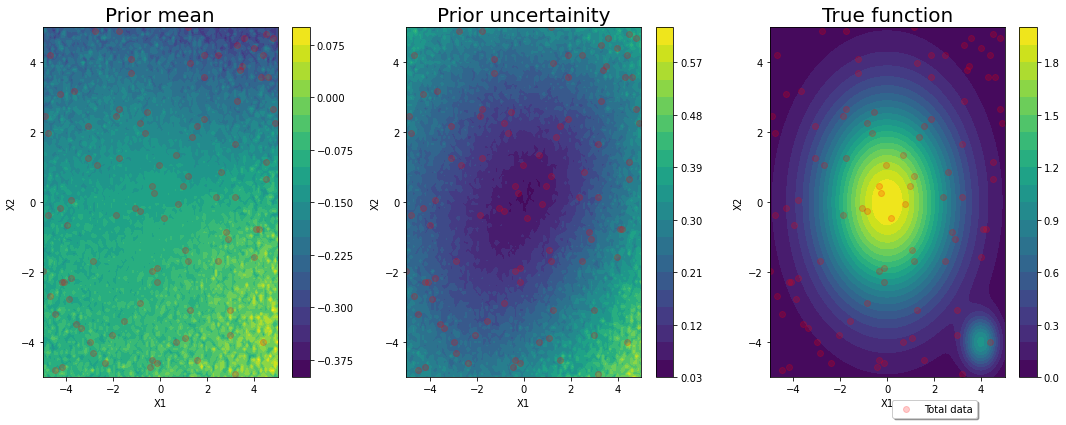

In [8]:
# Prior predictive plot
input_dim = 2  # 2-D input
hidden_l1_dim = 50
hidden_l2_dim = 50
hidden_l3_dim = 50
output_dim = 1

model = MLP(input_dim, hidden_l1_dim, hidden_l2_dim, hidden_l3_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

plot_posterior_predictive_2d(X_dataset, y_dataset, None, None, None, None, model)

# Probability of improvement

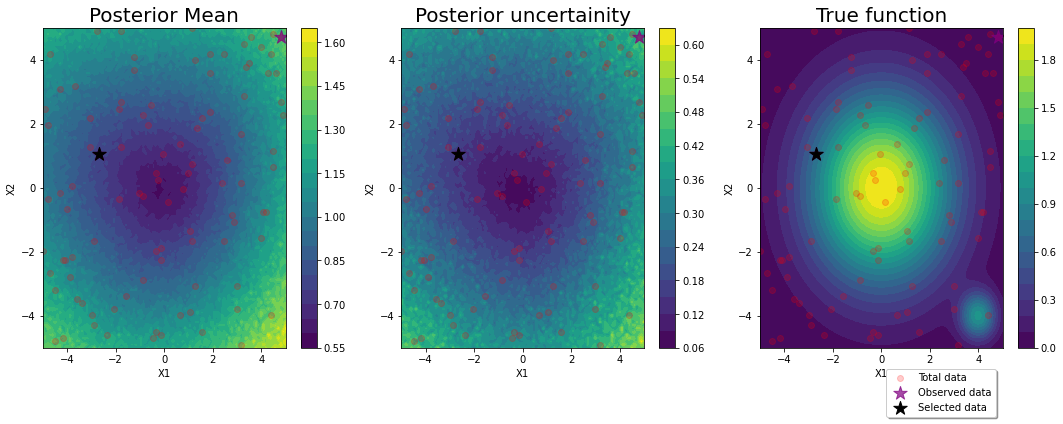

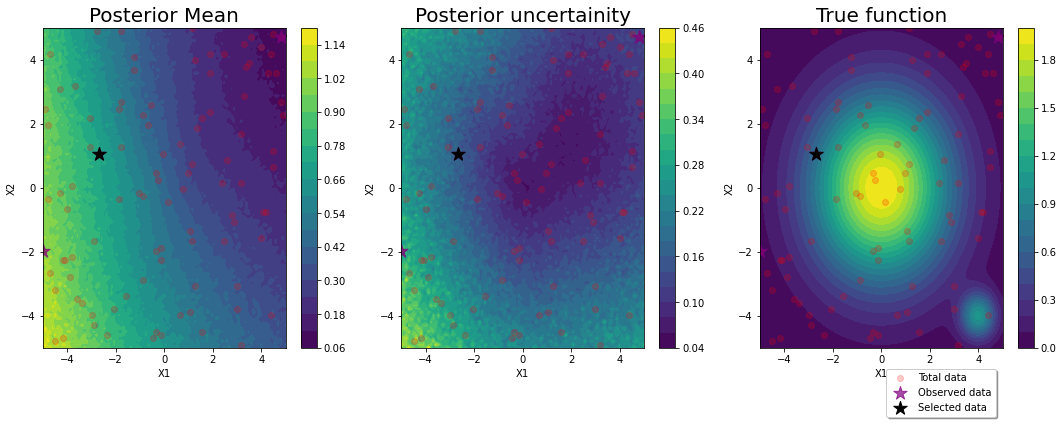

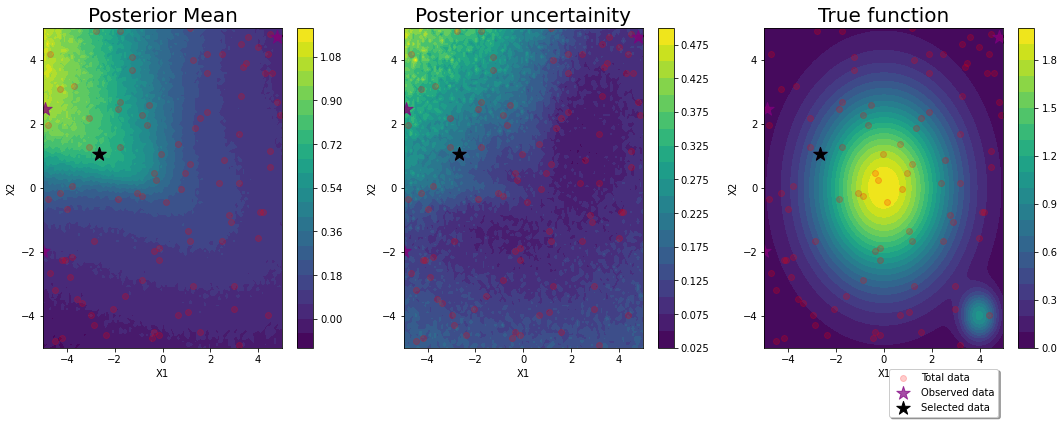

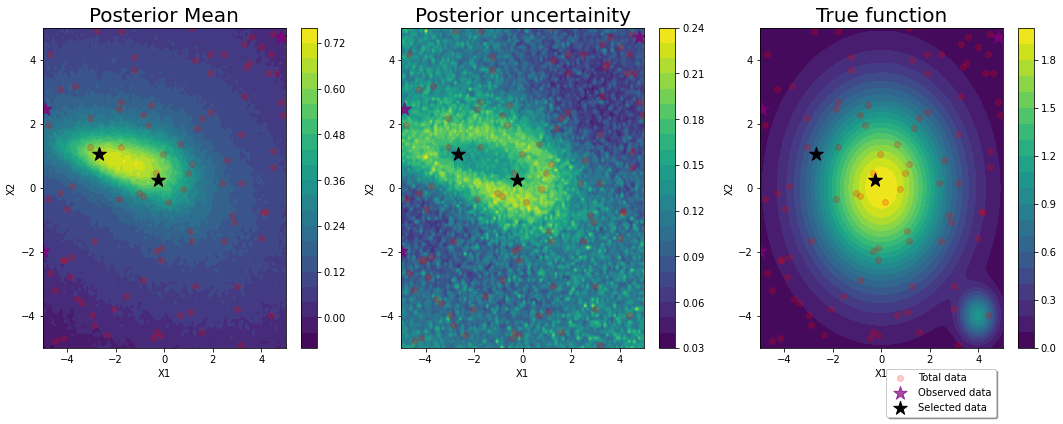

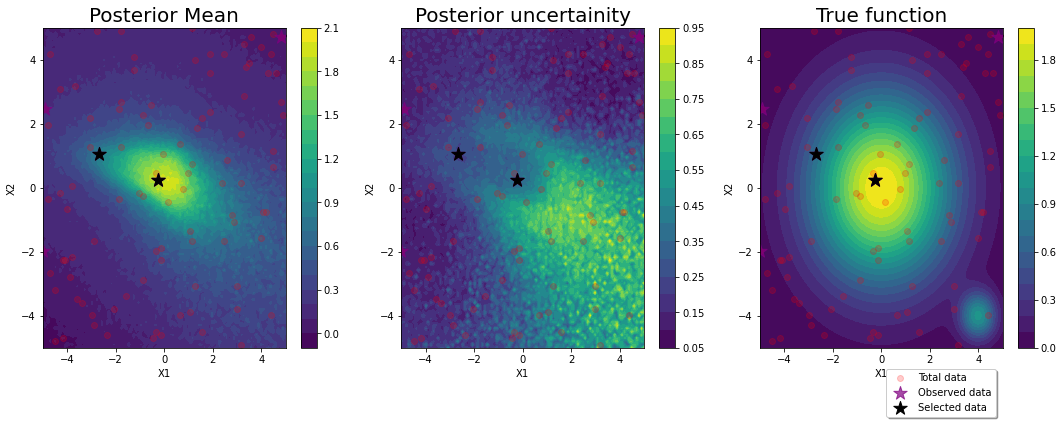

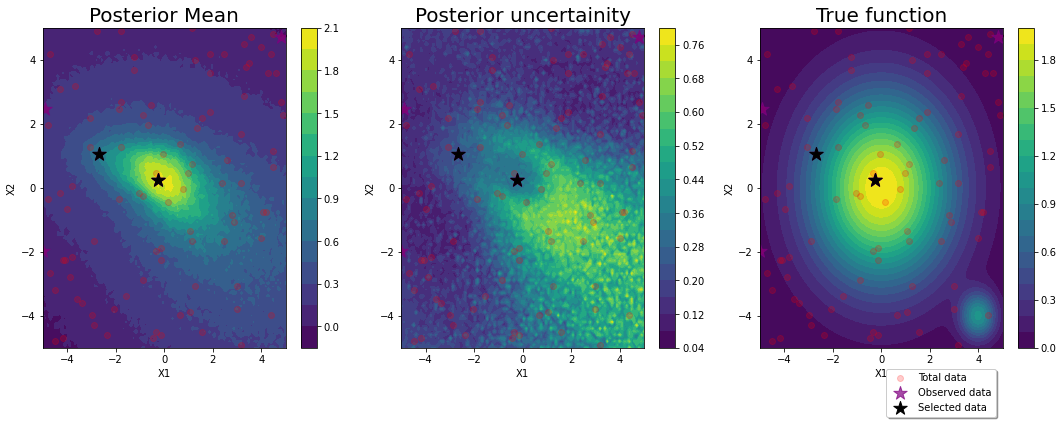

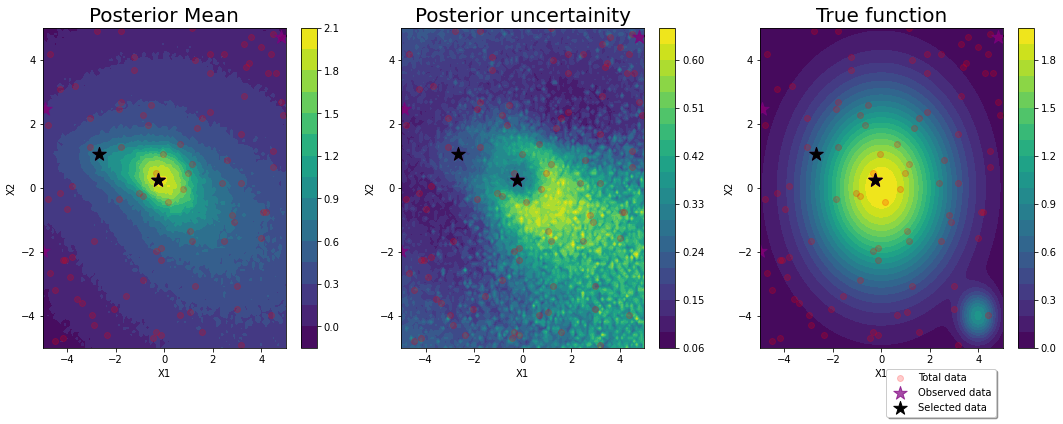

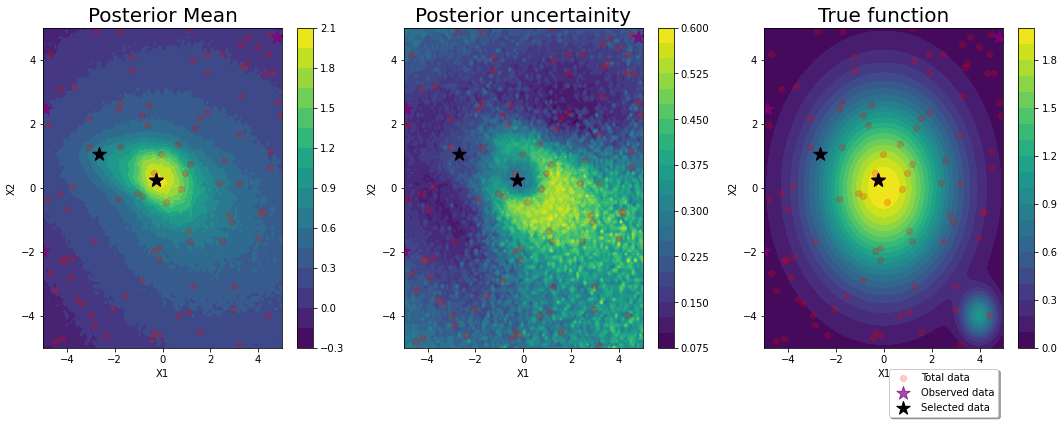

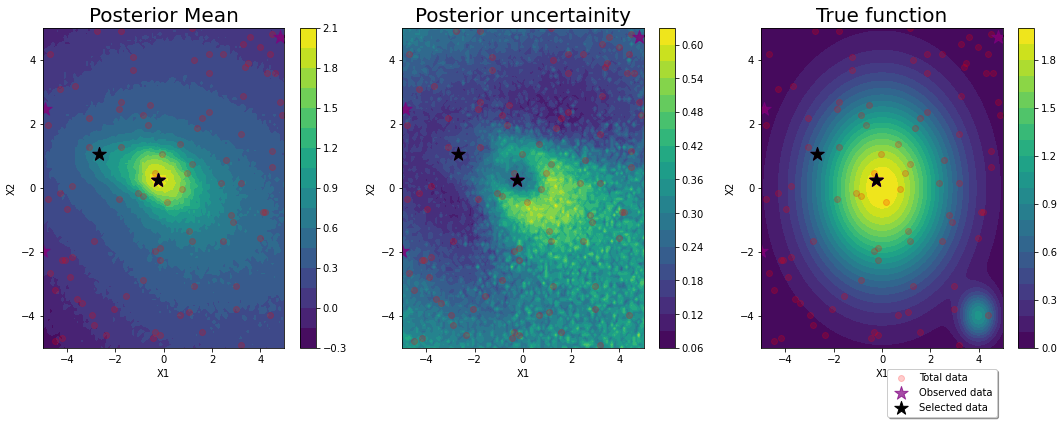

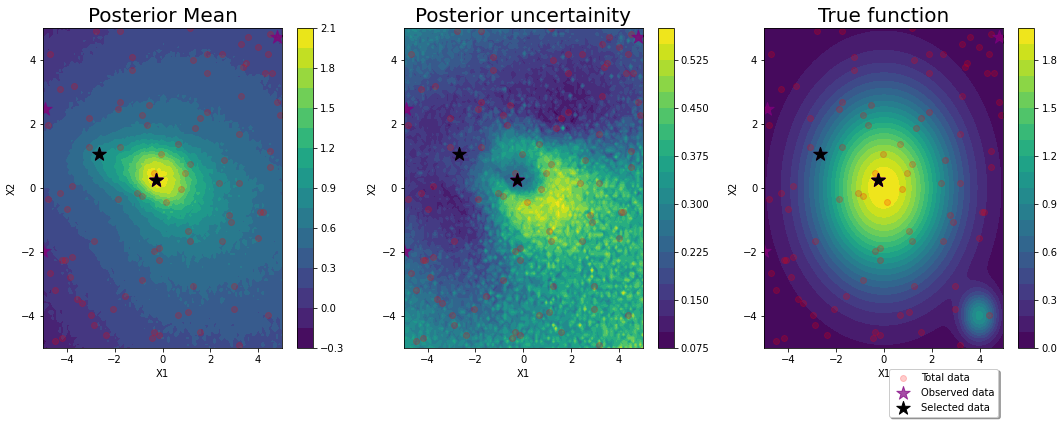

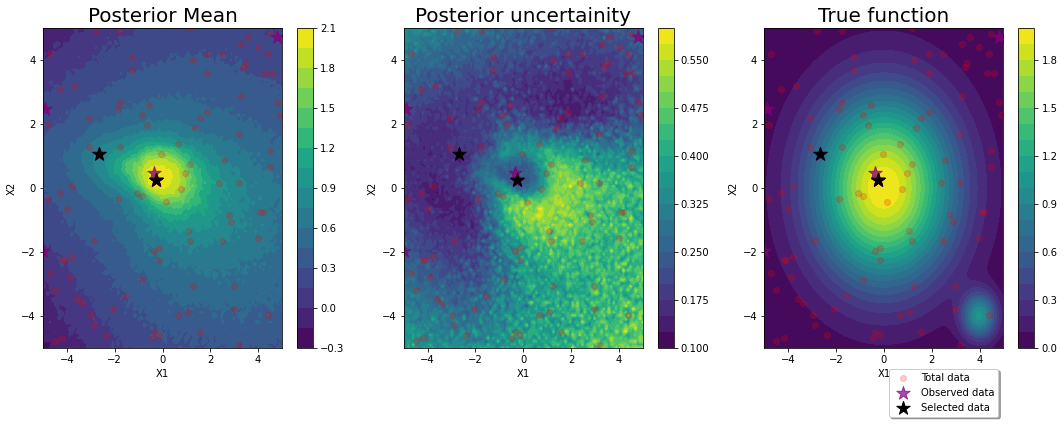

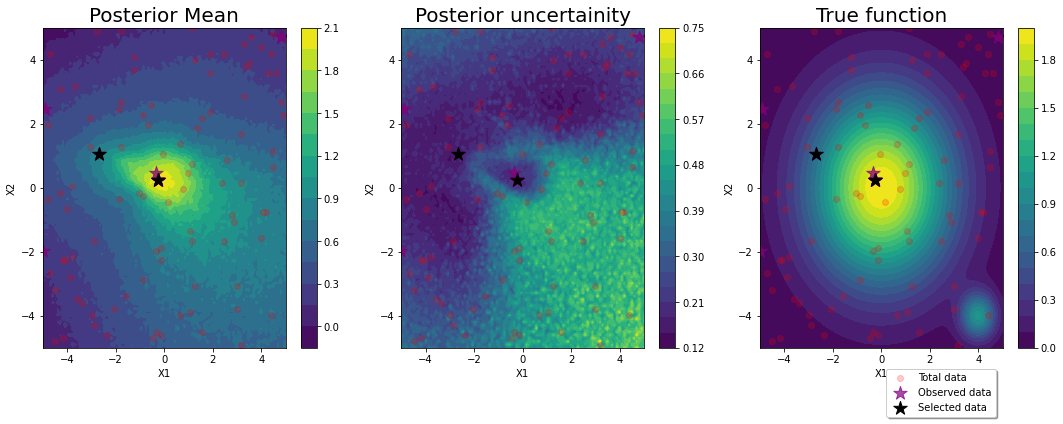

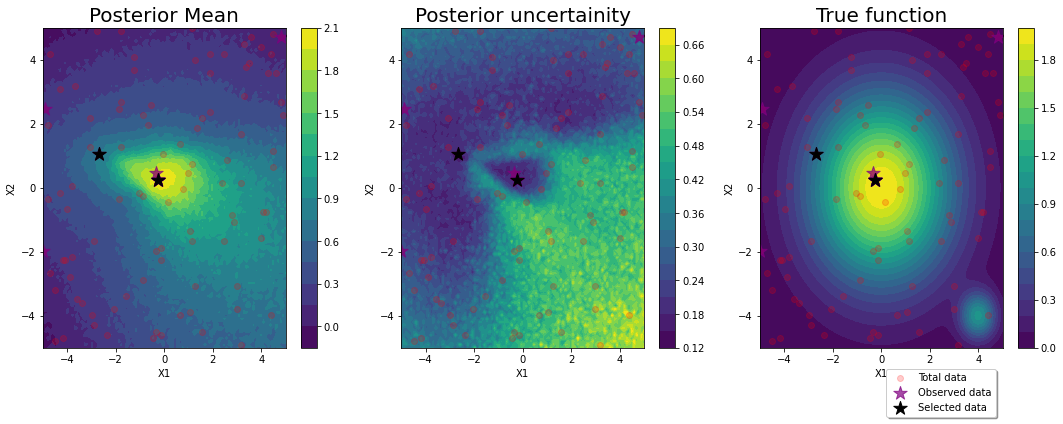

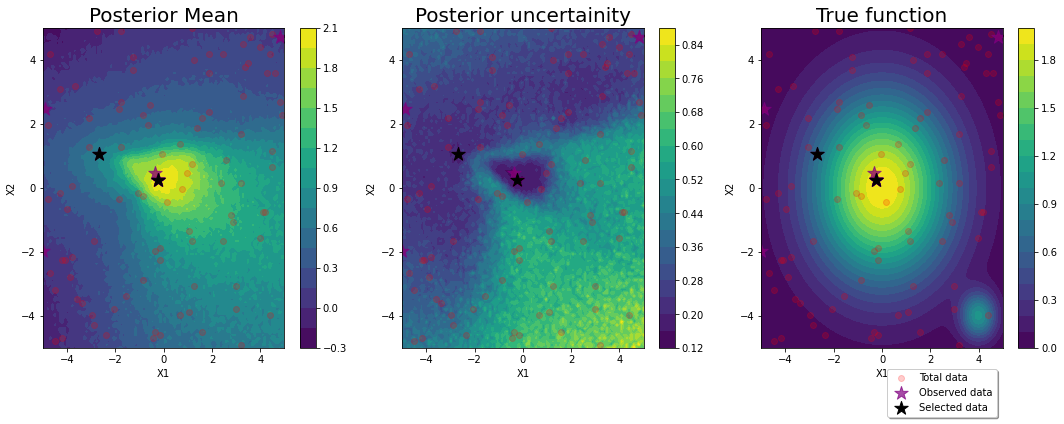

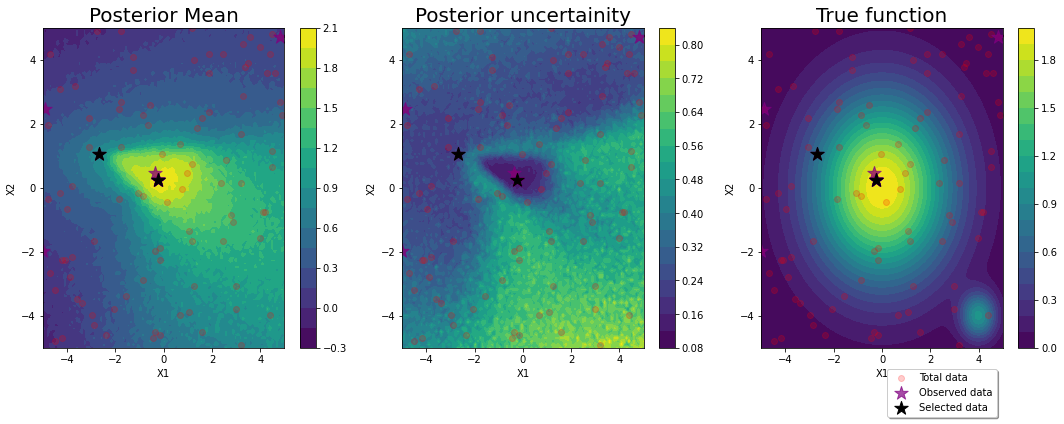

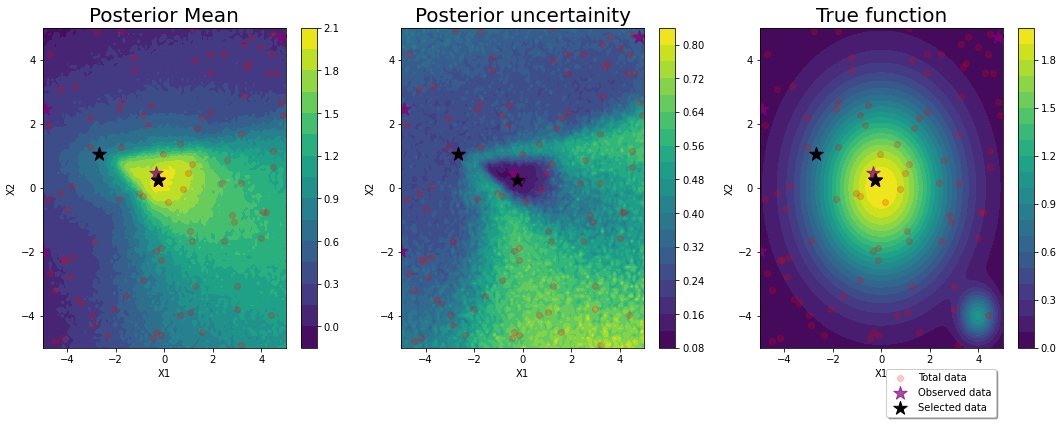

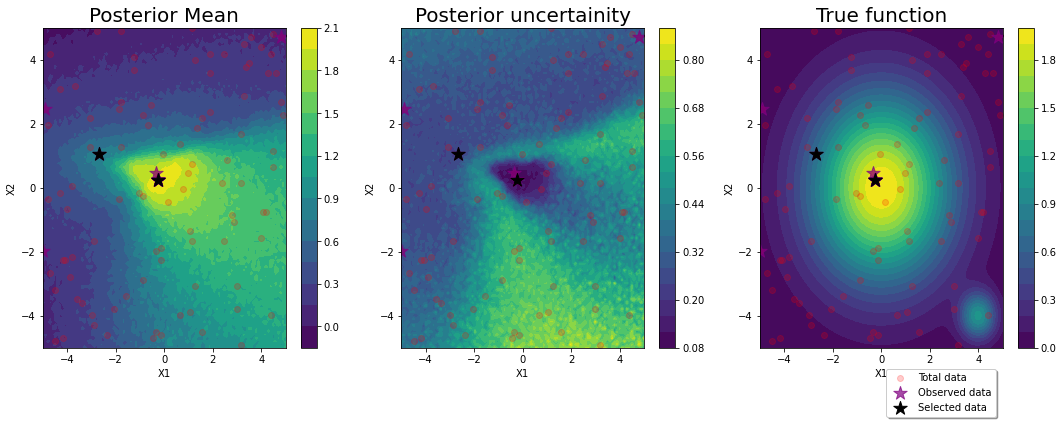

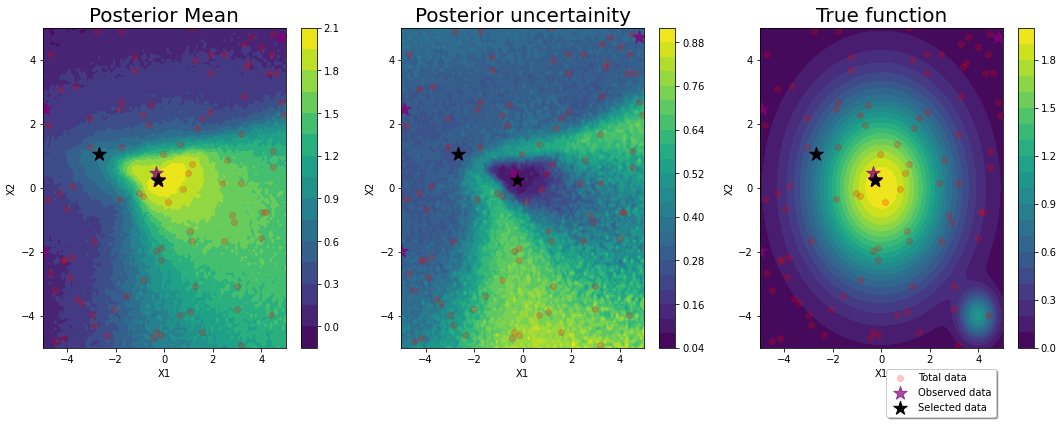

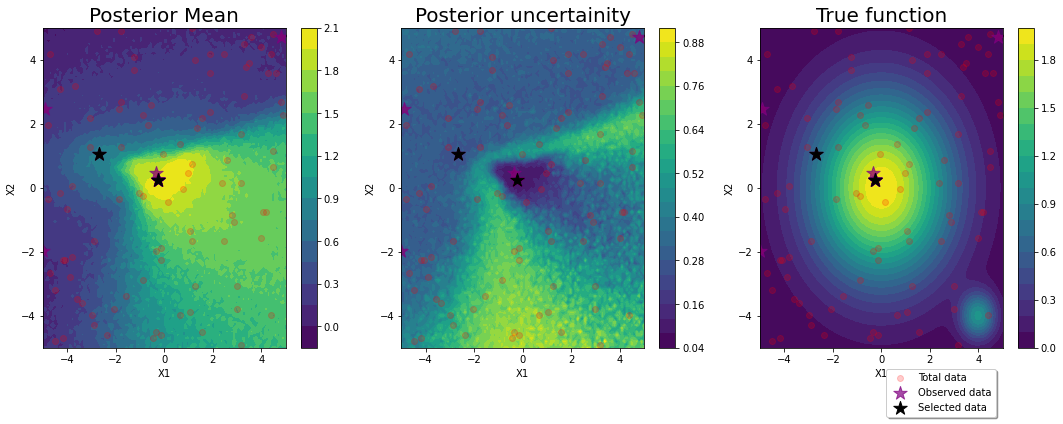

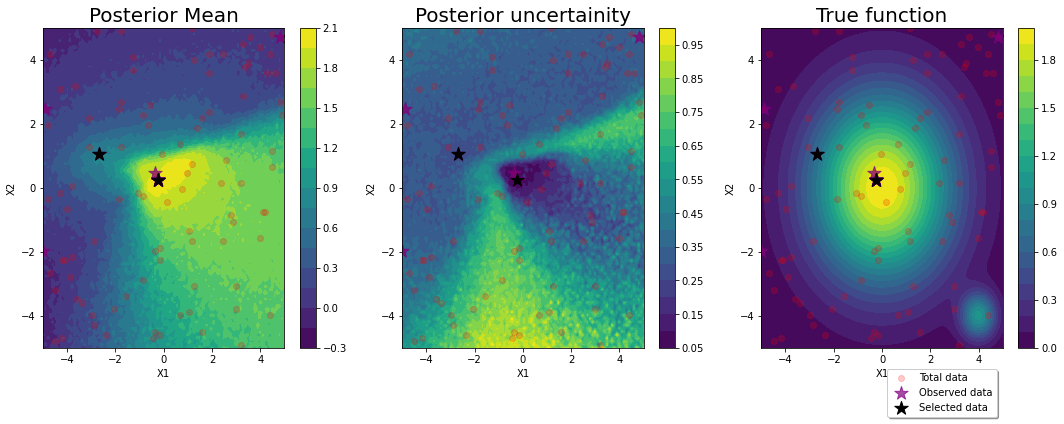

selected X:
tensor([[-2.6768,  1.0606],
        [-0.2525,  0.2525]])
Final y:
tensor([[0.8083],
        [2.0360]])


In [15]:
input_dim = 2  # 2-D input
hidden_l1_dim = 50
hidden_l2_dim = 50
hidden_l3_dim = 50
output_dim = 1

model = MLP(input_dim, hidden_l1_dim, hidden_l2_dim, hidden_l3_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


# Bayesian optimization loop
num_iterations = 20
acquisition_function = probability_of_improvement  # Choose acquisition function

# Randomly select initial point
ind = np.random.randint(100)
X_new = X_dataset[ind].reshape(1, -1)
y_new = y_dataset[ind].reshape(1, -1)

# Run Bayesian optimization loop
X_train, y_train,max_values_PI = bayesian_optimization_loop_2d(model, num_iterations, acquisition_function, X_new, y_new, X_dataset, y_dataset, optimizer, criterion)
print("selected X:")
print(X_train)
print("Final y:")
print(y_train)
# print("Max y_PI:")
# print(max_values_PI)

# Upper confidence bound

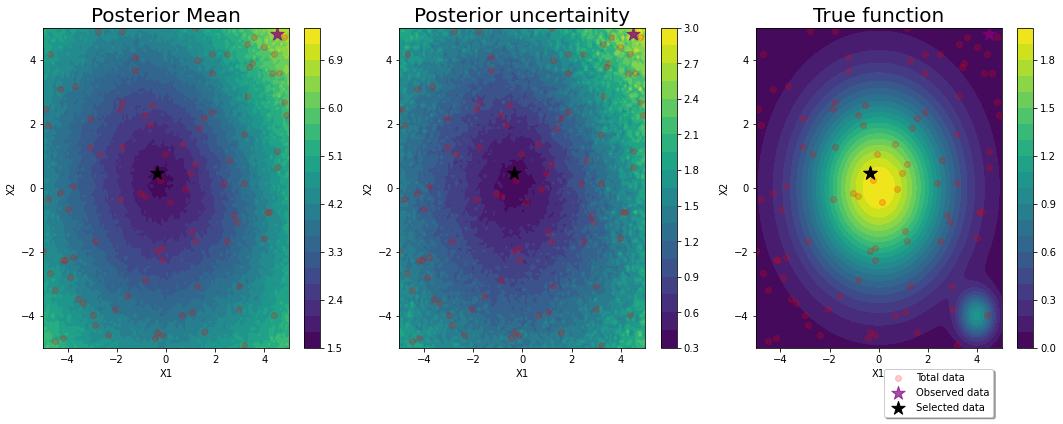

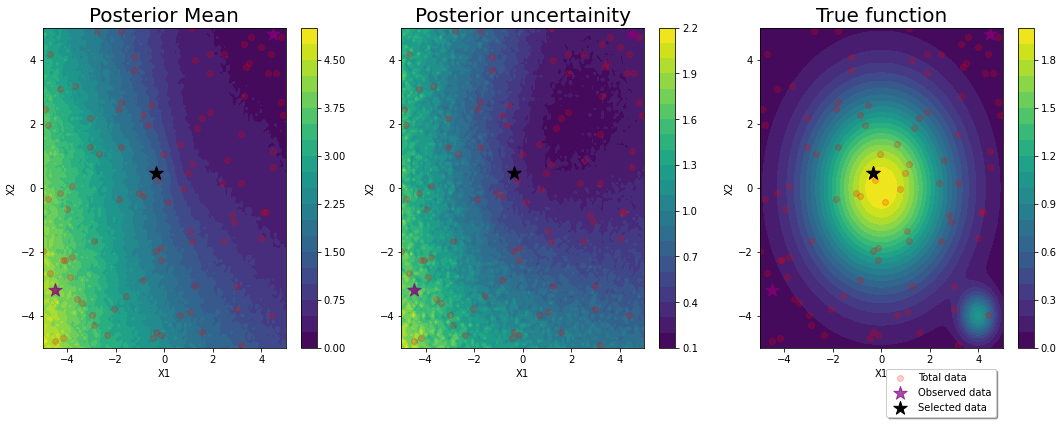

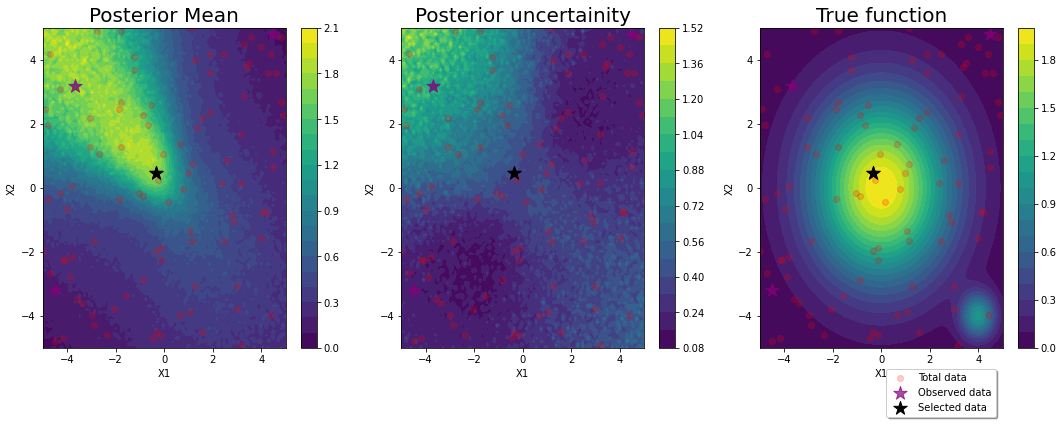

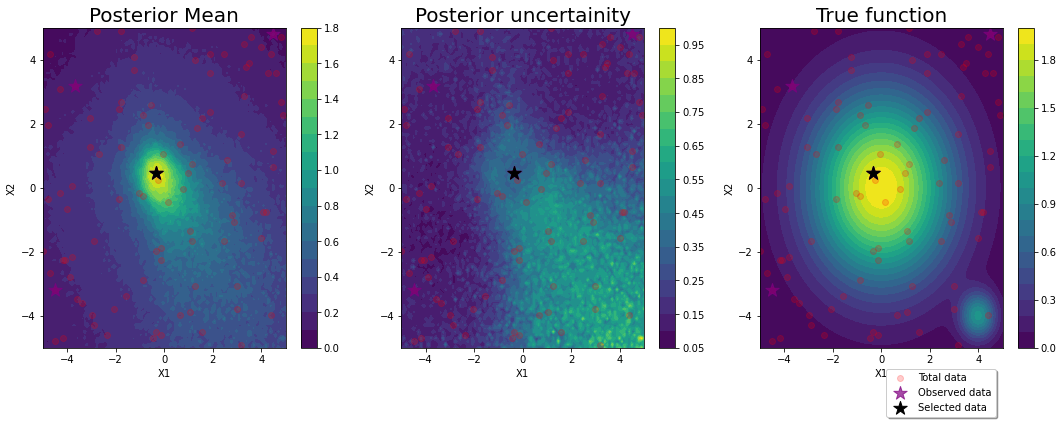

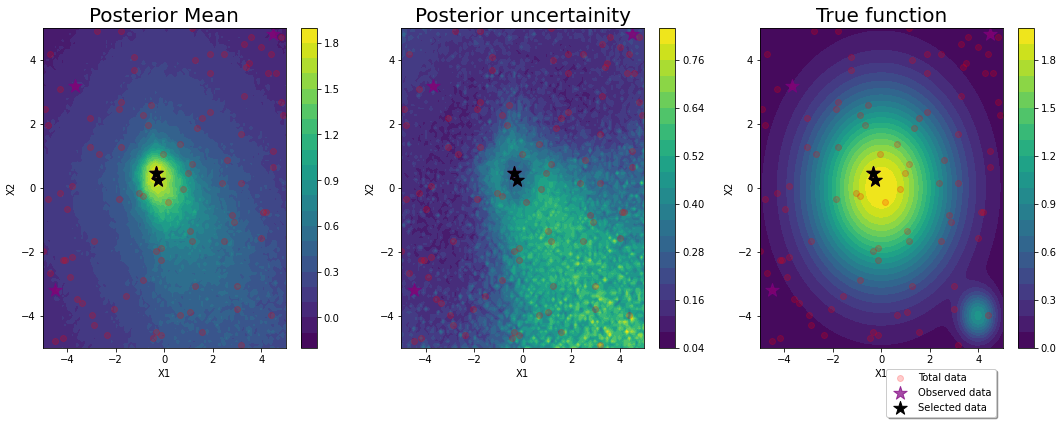

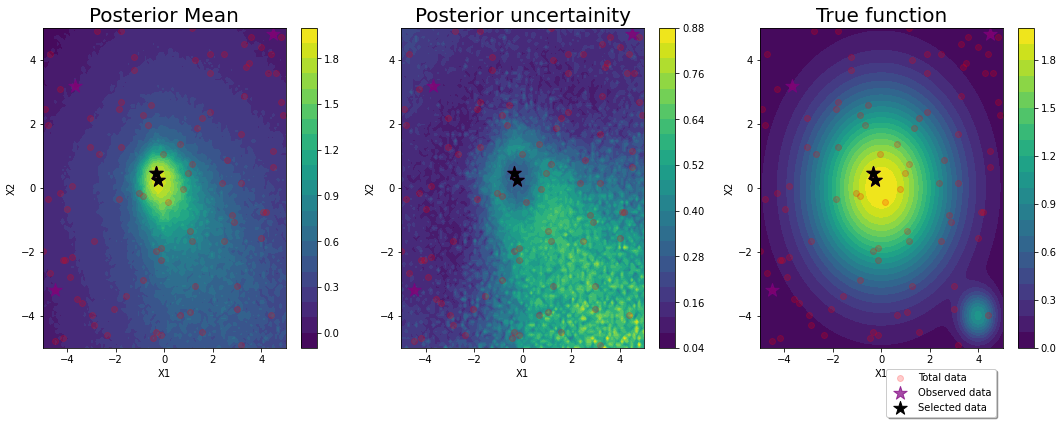

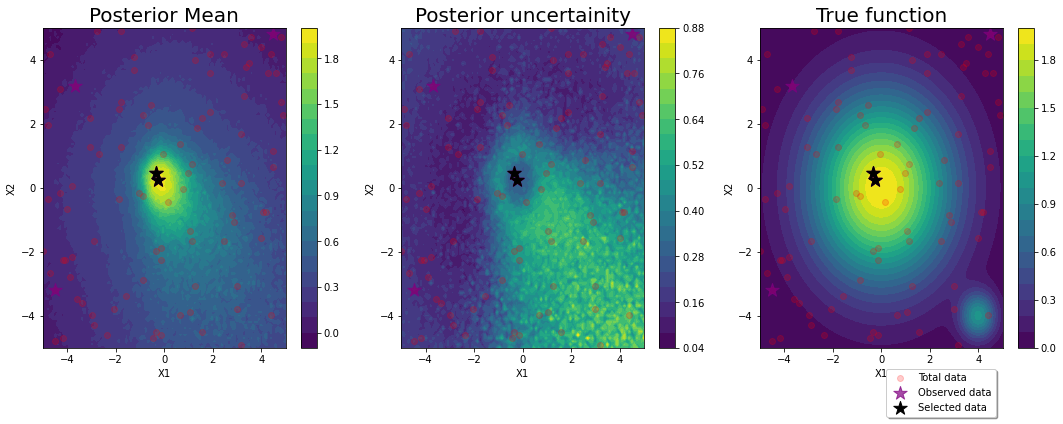

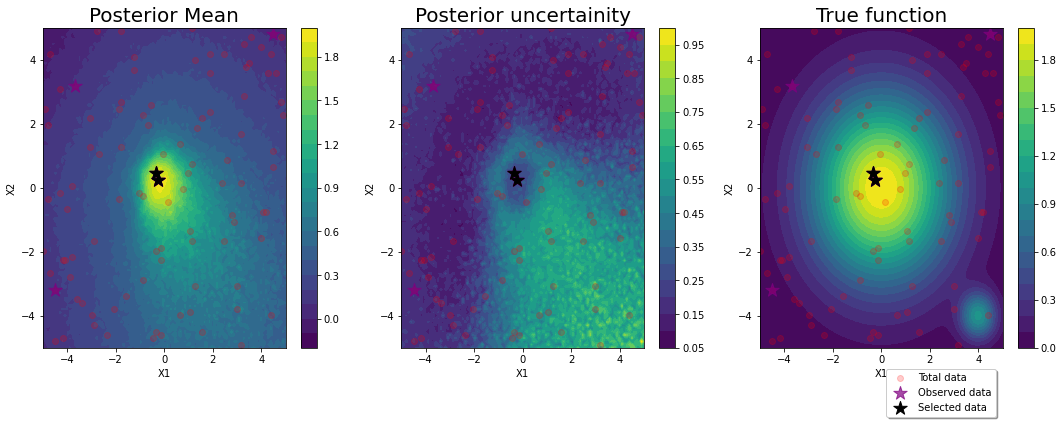

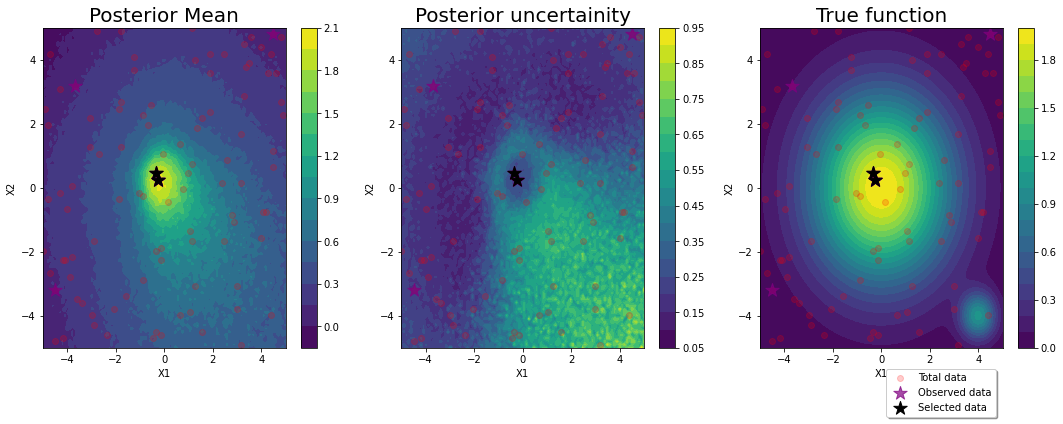

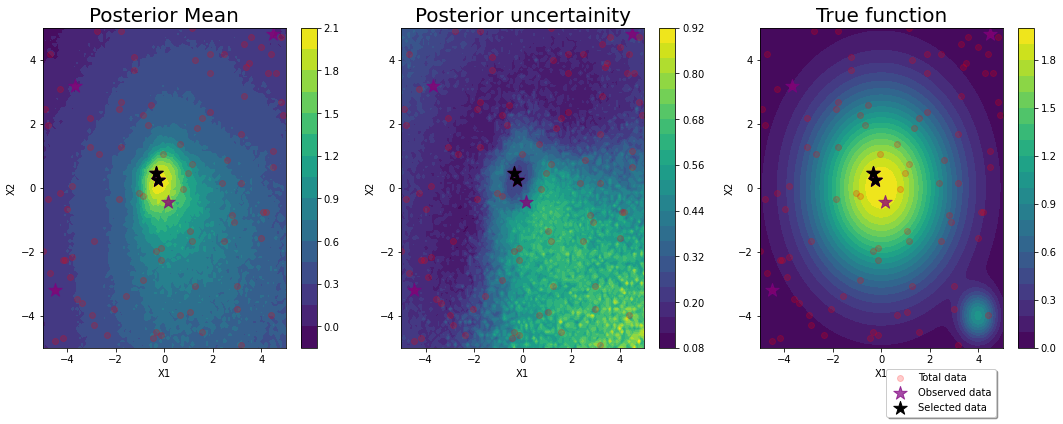

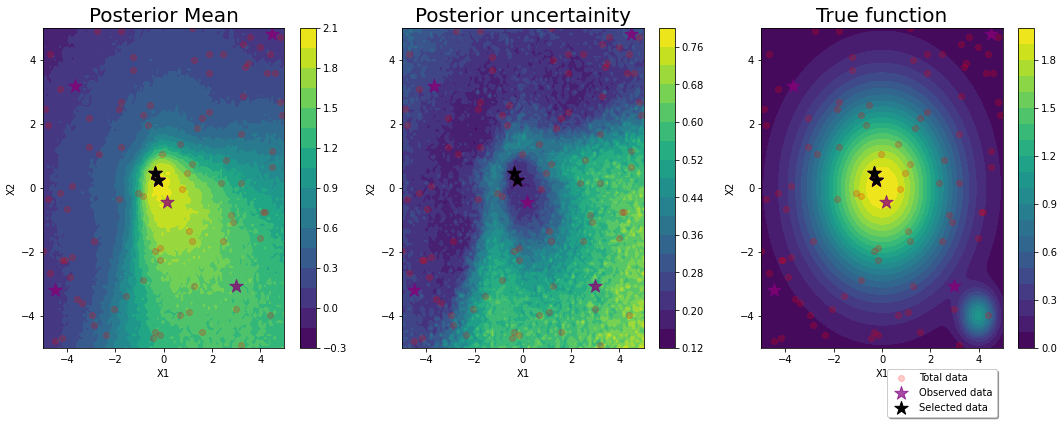

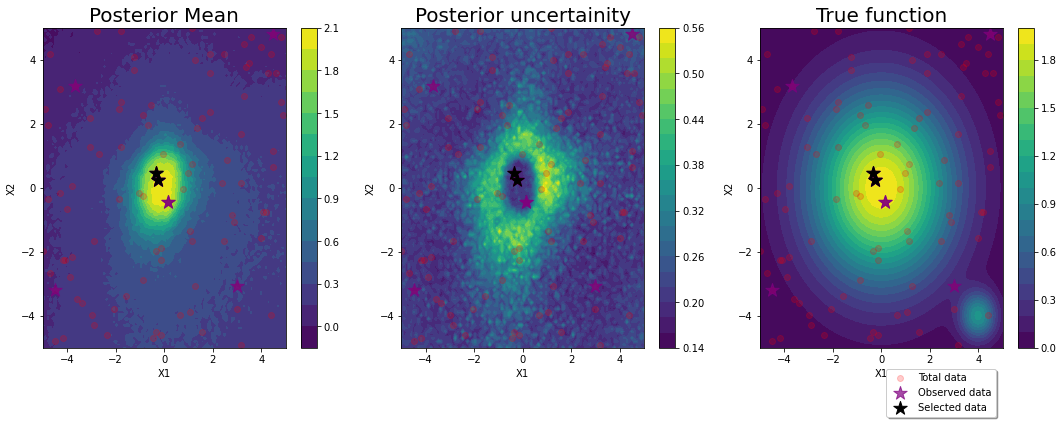

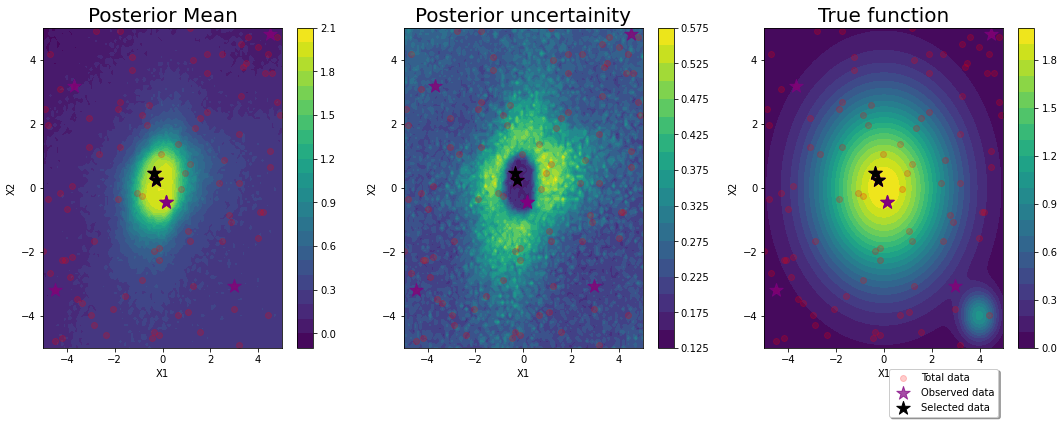

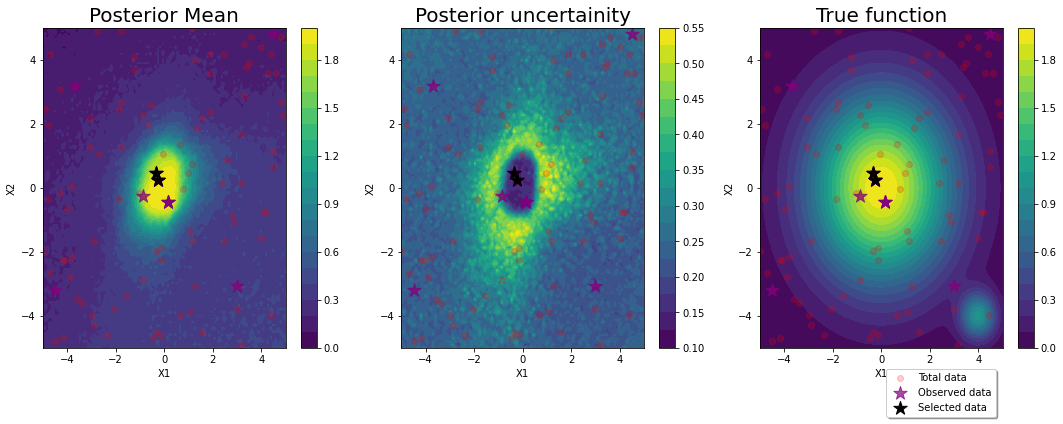

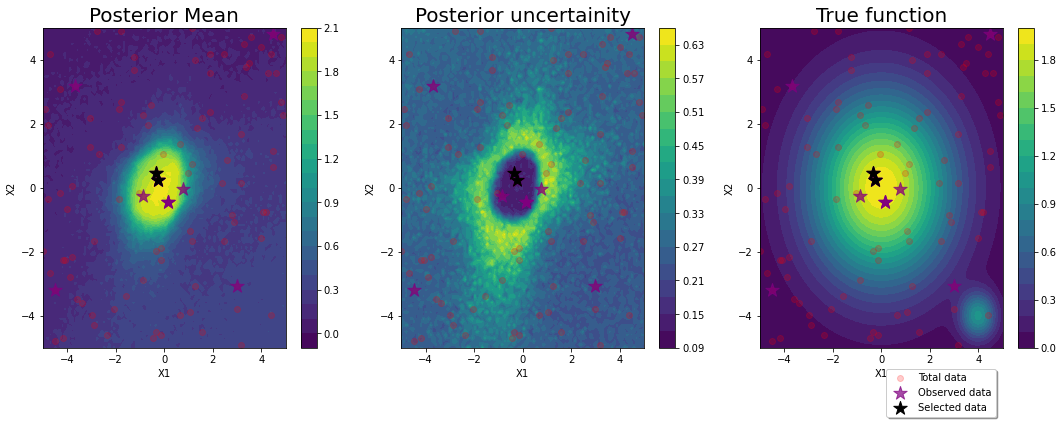

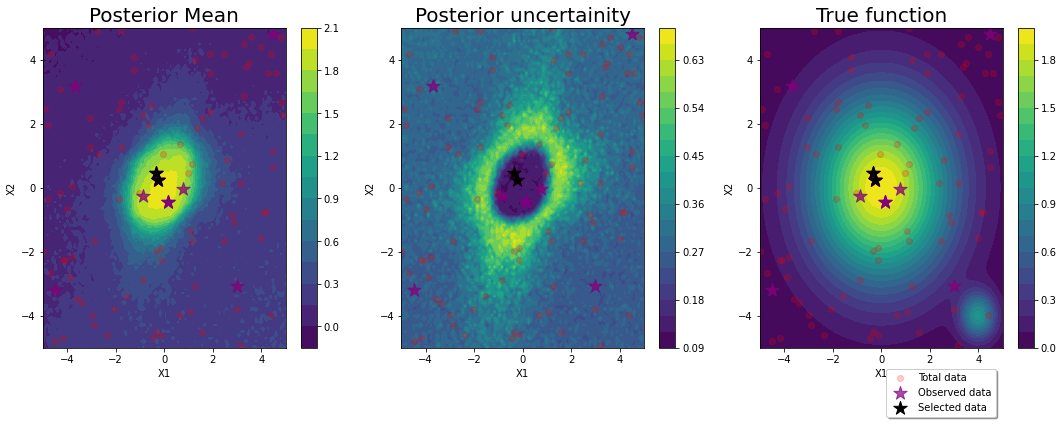

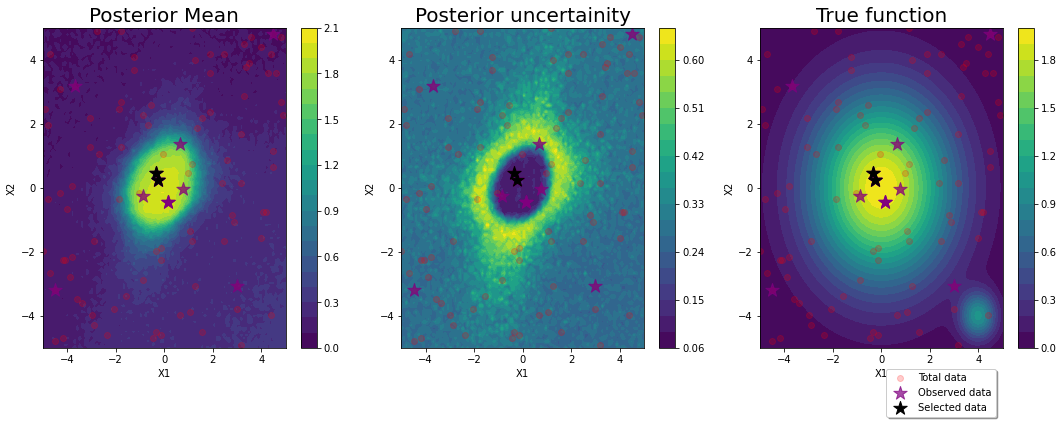

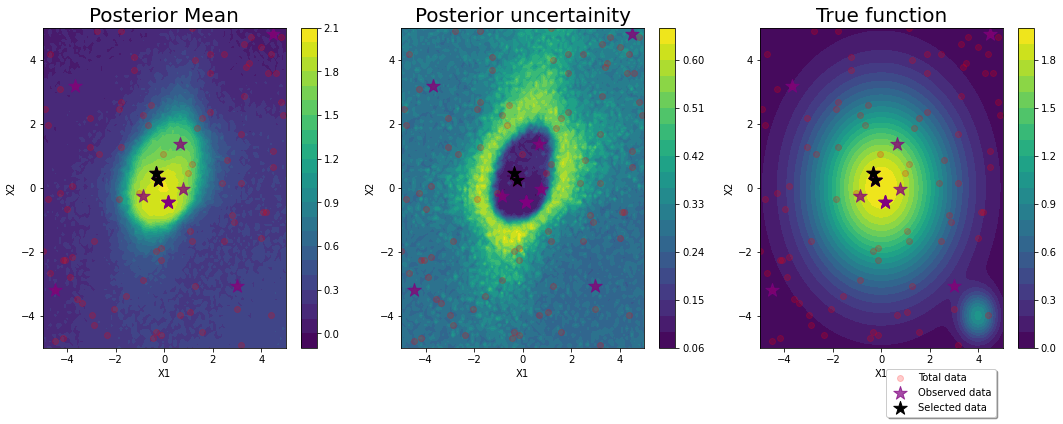

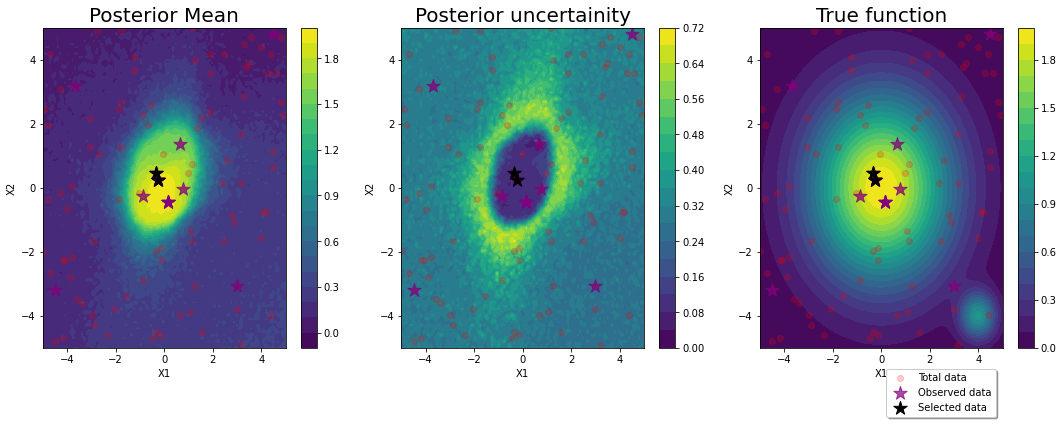

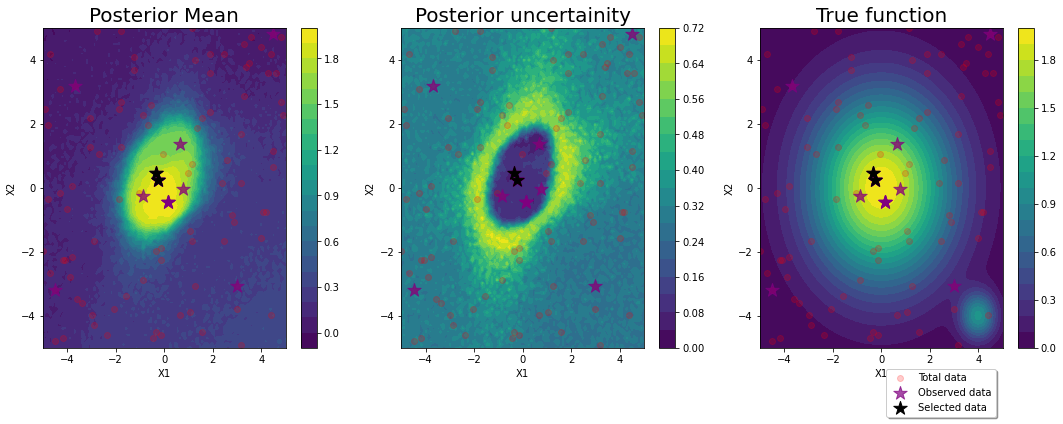

selected X:
tensor([[-0.3535,  0.4545],
        [-0.2525,  0.2525]])
Final y:
tensor([[1.8351],
        [2.0360]])


In [10]:
input_dim = 2  # 2-D input
hidden_l1_dim = 50
hidden_l2_dim = 50
hidden_l3_dim = 50
output_dim = 1

model = MLP(input_dim, hidden_l1_dim, hidden_l2_dim, hidden_l3_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


# Bayesian optimization loop
num_iterations = 20
acquisition_function = upper_confidence_bound  # Choose acquisition function

# Randomly select initial point
ind = np.random.randint(100)
X_new = X_dataset[ind].reshape(1, -1)
y_new = y_dataset[ind].reshape(1, -1)

# Run Bayesian optimization loop
X_train, y_train,max_values_UCB = bayesian_optimization_loop_2d(model, num_iterations, acquisition_function, X_new, y_new, X_dataset, y_dataset, optimizer, criterion)
print("selected X:")
print(X_train)
print("Final y:")
print(y_train)
# print("Max y_PI:")
# print(max_values_UCB)

# Random search

In [11]:
def random_search_loop_2d(model, num_iterations, X_new, y_new,X_dataset, y_dataset, optimizer, criterion, num_epochs=1000):
    X_data_full = X_dataset.clone()
    y_data_full = y_dataset.clone()
    X_train = X_new.clone()
    y_train = y_new.clone()
    X_obs = X_train.clone()
    y_obs = y_train.clone()
    max_values =[]
    for i in range(num_iterations):
        

        # Update the model with the new data point
        model = update(model, X_obs, y_obs, optimizer, criterion, num_epochs=num_epochs)
        
        # Perform MC dropout prediction
        mean_predictions, std_predictions = posterior_predictive(model, X_dataset, p=0.5)
        
        y_max = y_train.max()
        
        # Randomly select a point from the dataset
        idx = np.random.randint(len(X_dataset))
        next_idx_2D = torch.tensor([[idx]], dtype=torch.long)
        next_x = X_dataset[next_idx_2D].numpy().reshape(1, -1)
        next_y = y_dataset[next_idx_2D]

        if next_y > y_max:
            # Add new point to training data
            X_train = torch.cat((X_train, torch.tensor(next_x)))
            y_train = torch.cat((y_train, next_y))



            # Append next_x and next_y to X_obs and y_obs
        X_obs = torch.cat((X_obs, torch.tensor(next_x)))
        y_obs = torch.cat((y_obs, next_y))

        max_values.append(float(y_max))
        plot_posterior_predictive_2d(X_data_full, y_data_full, X_obs.detach().numpy(), y_obs.detach().numpy(), X_train.detach().numpy(), y_train.detach().numpy(), model)

        
    return X_train, y_train, max_values

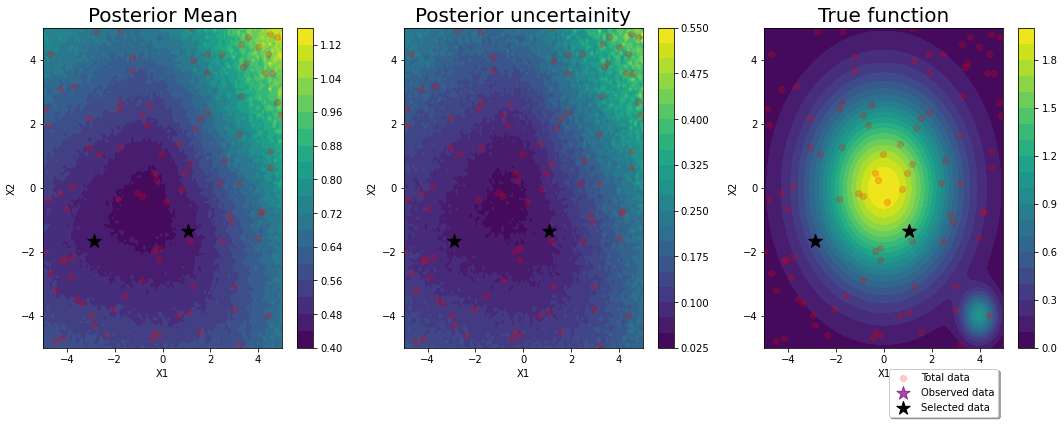

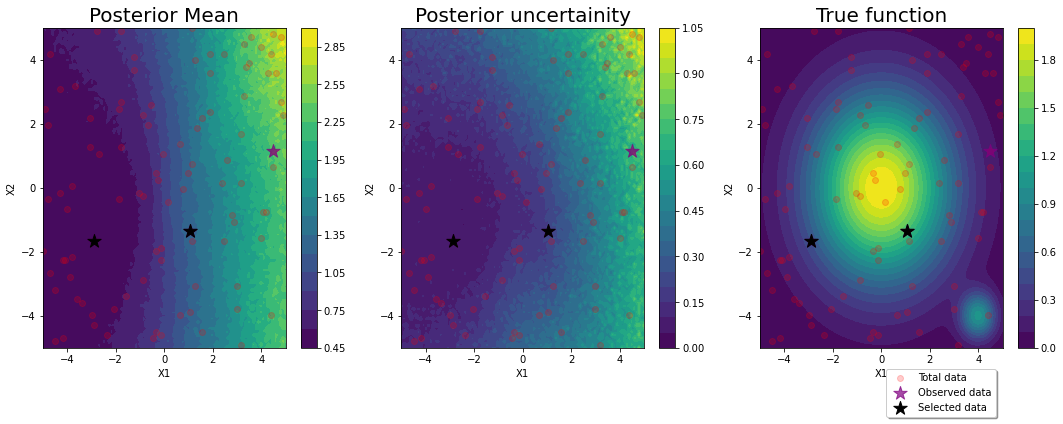

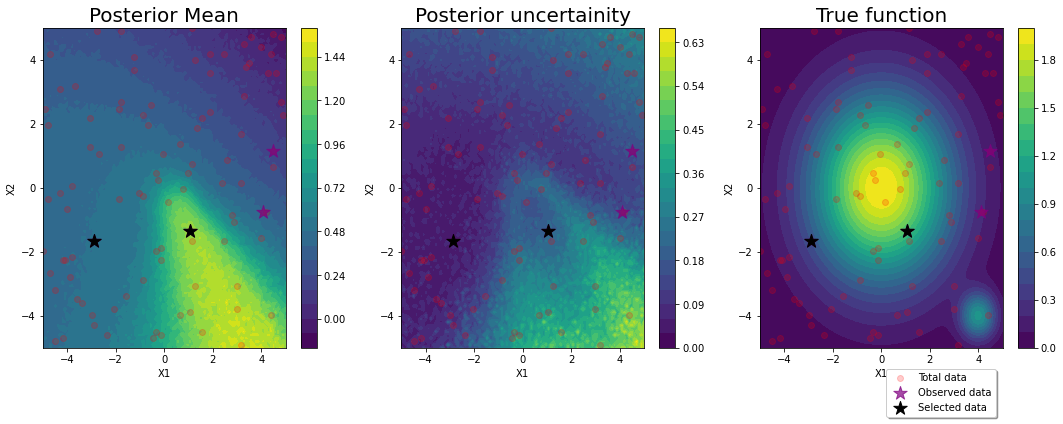

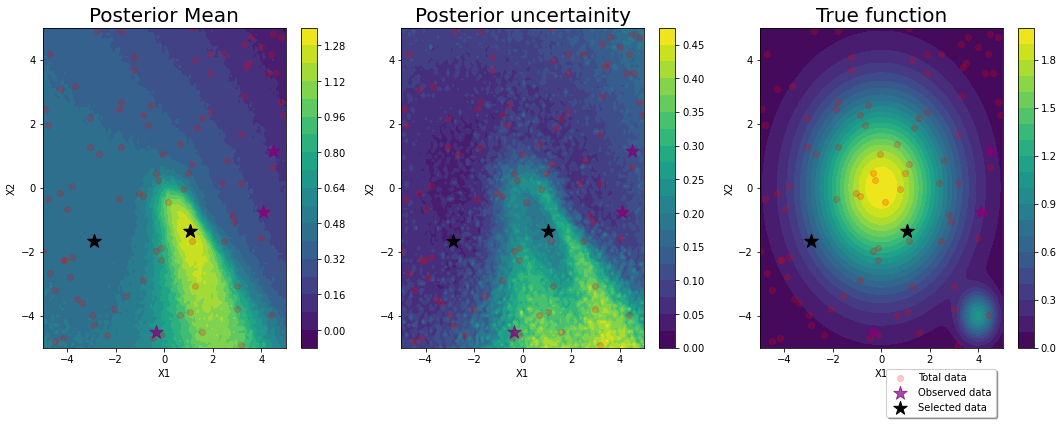

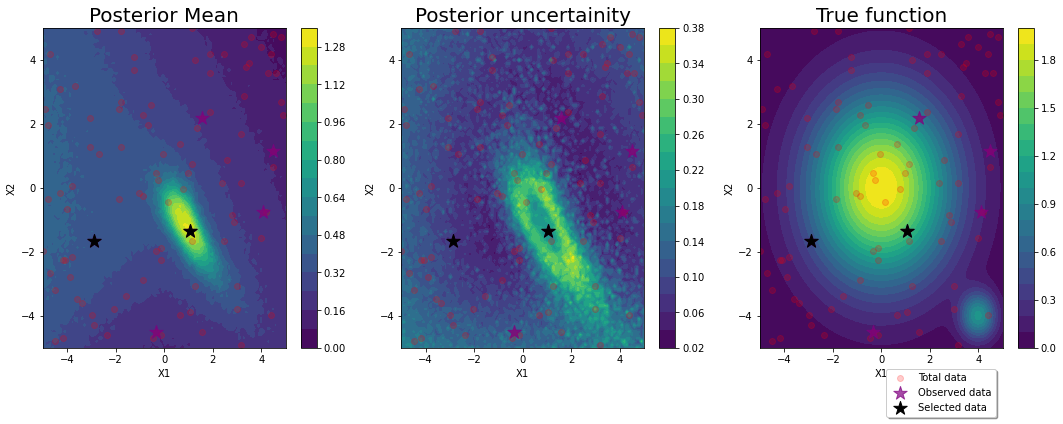

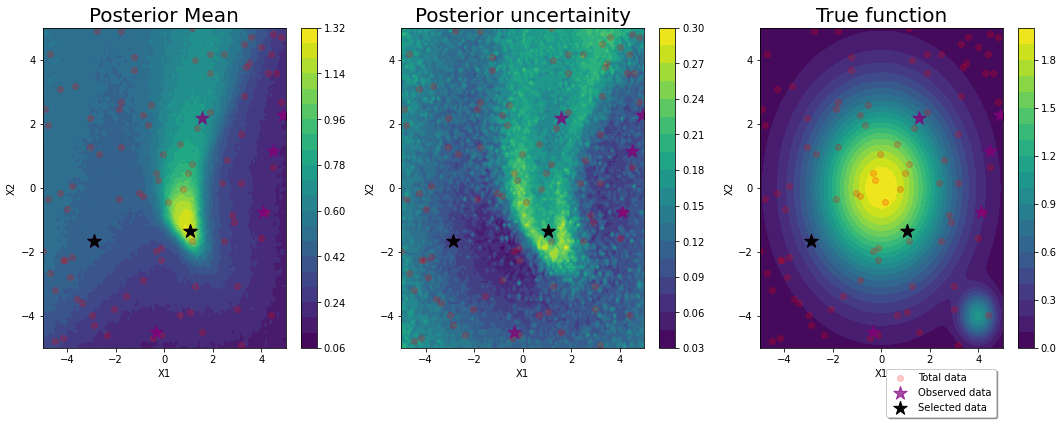

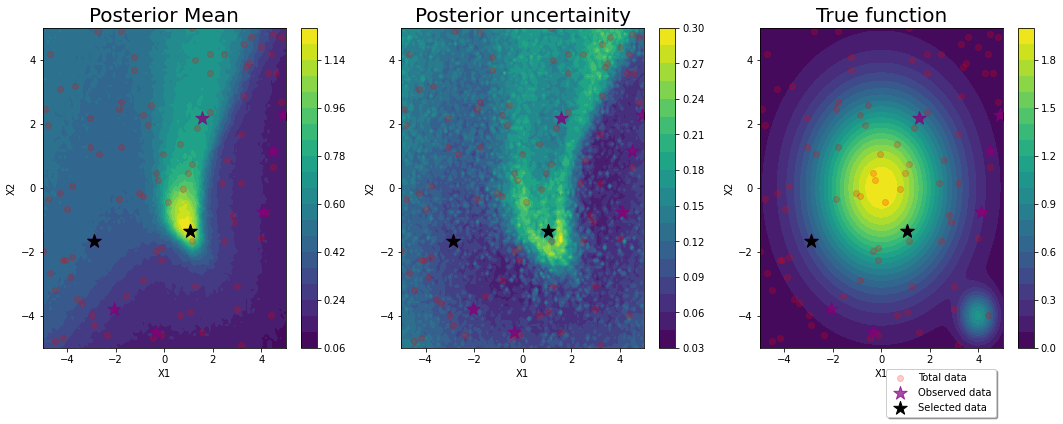

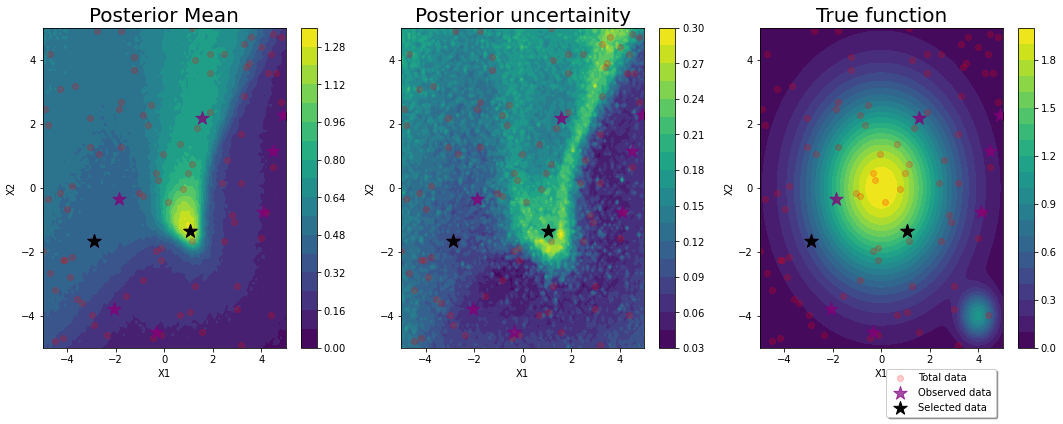

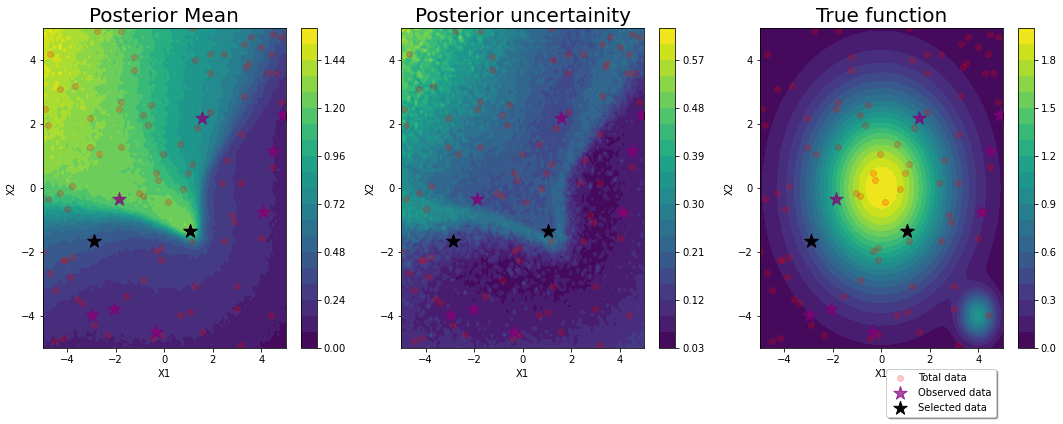

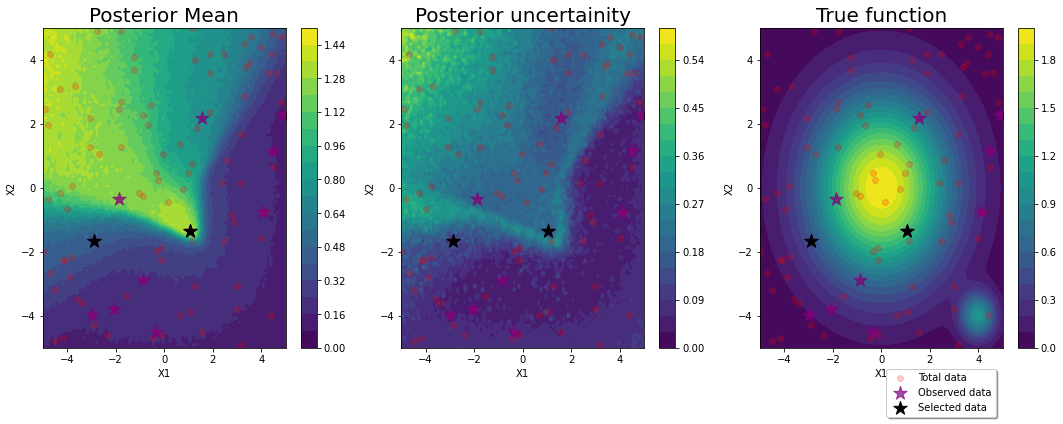

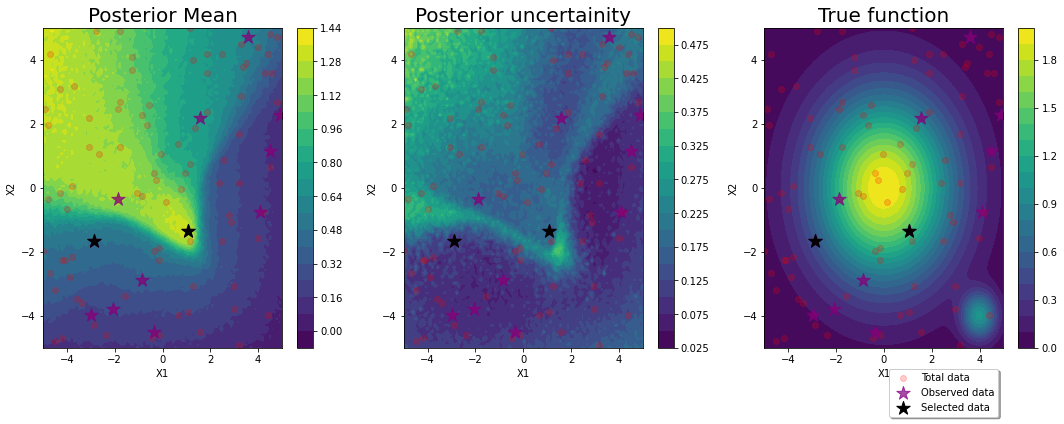

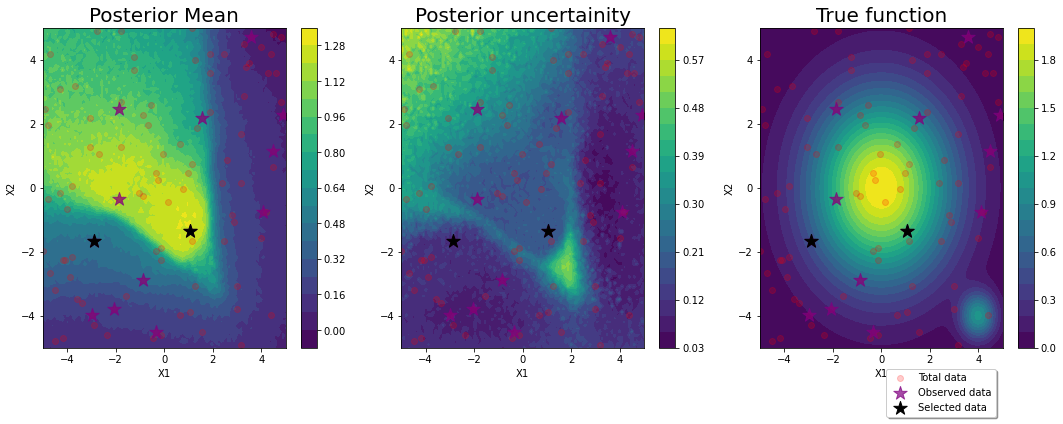

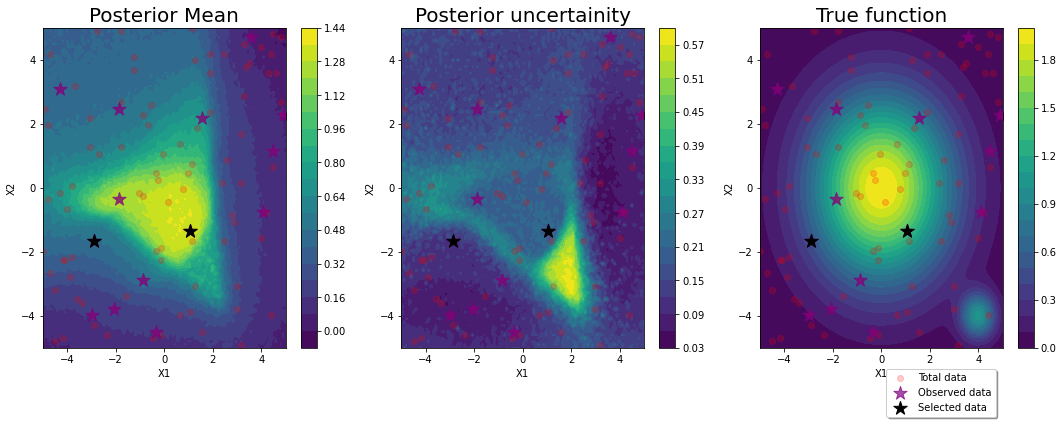

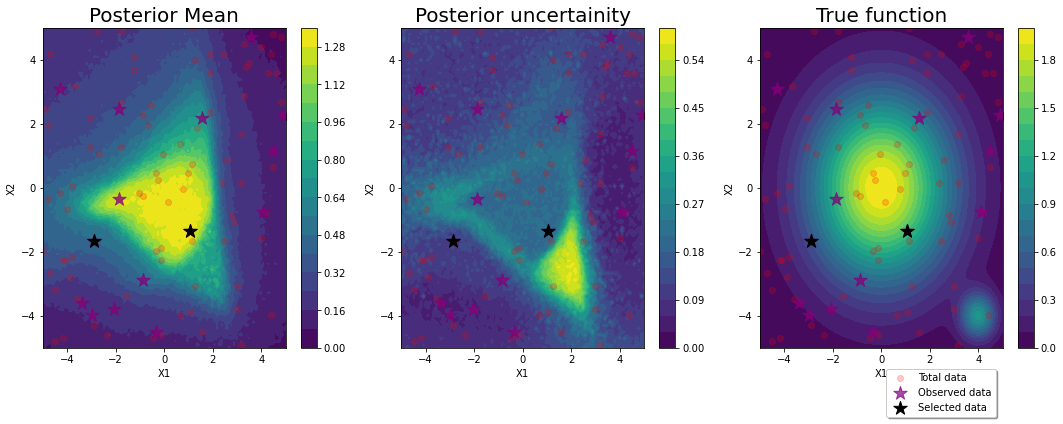

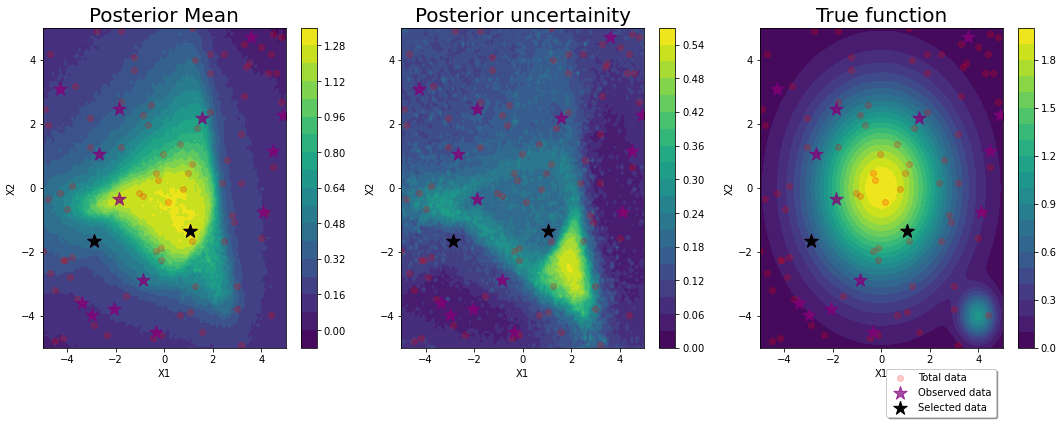

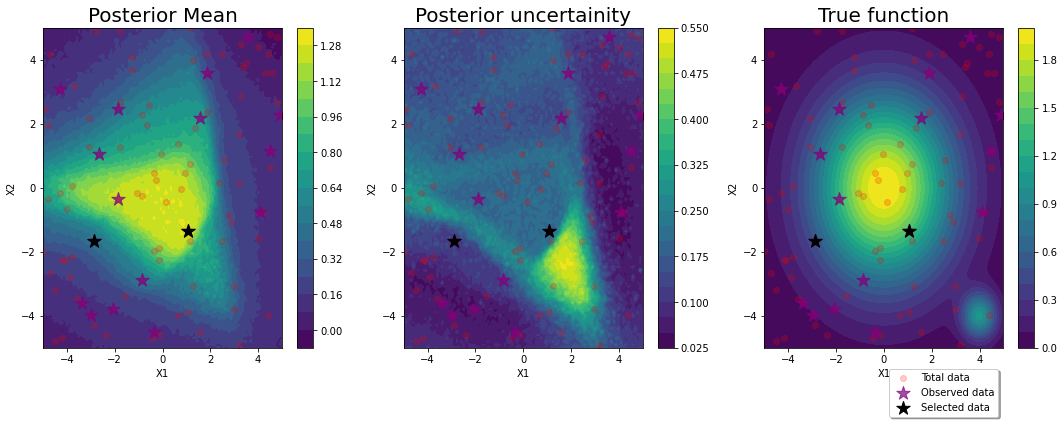

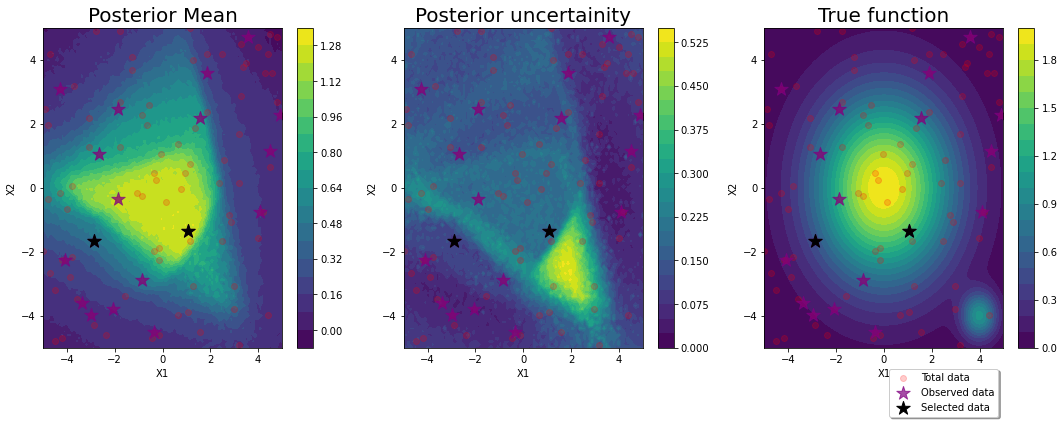

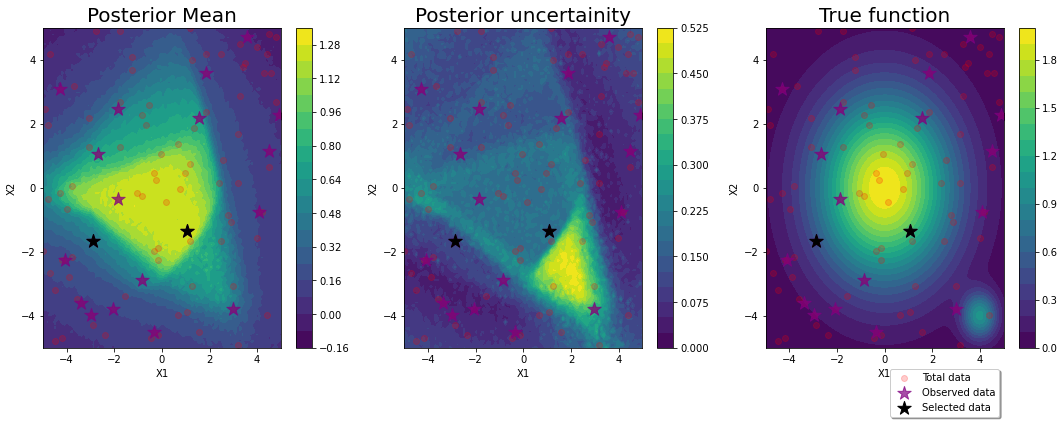

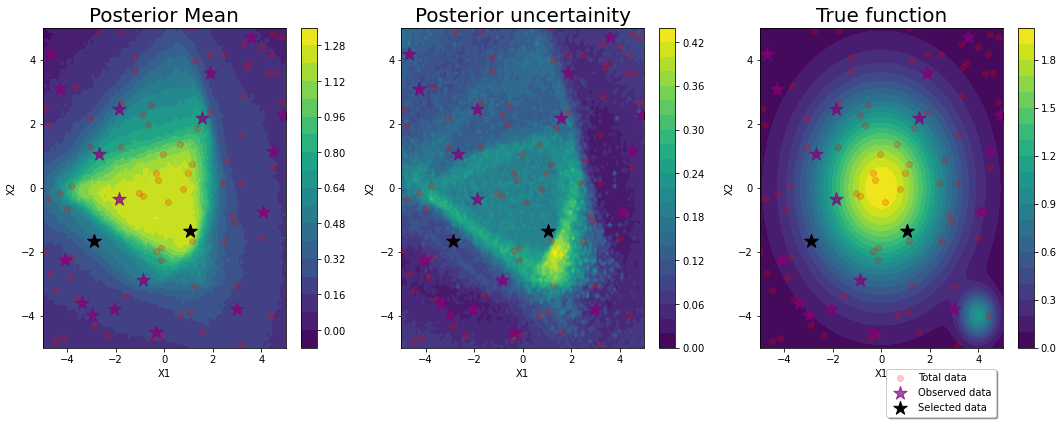

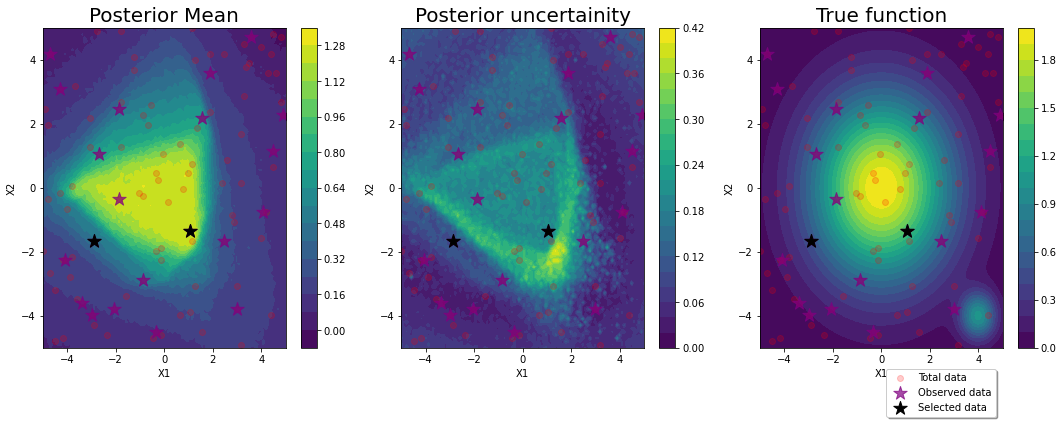

selected X:
tensor([[-2.8788, -1.6667],
        [ 1.0606, -1.3636]])
Final y:
tensor([[0.4683],
        [1.3443]])


In [12]:
input_dim = 2  # 2-D input
hidden_l1_dim = 50
hidden_l2_dim = 50
hidden_l3_dim = 50
output_dim = 1

model = MLP(input_dim, hidden_l1_dim, hidden_l2_dim, hidden_l3_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


# Bayesian optimization loop
num_iterations = 20

# Randomly select initial point
ind = np.random.randint(100)
X_new = X_dataset[ind].reshape(1, -1)
y_new = y_dataset[ind].reshape(1, -1)

# Run Random search loop
X_train, y_train, max_values_RS = random_search_loop_2d(model, num_iterations,  X_new, y_new, X_dataset, y_dataset, optimizer,criterion)
print("selected X:")
print(X_train)
print("Final y:")
print(y_train)
# print("Max y_RS:")
# print(max_values_RS)

# Comparison of different search techniques

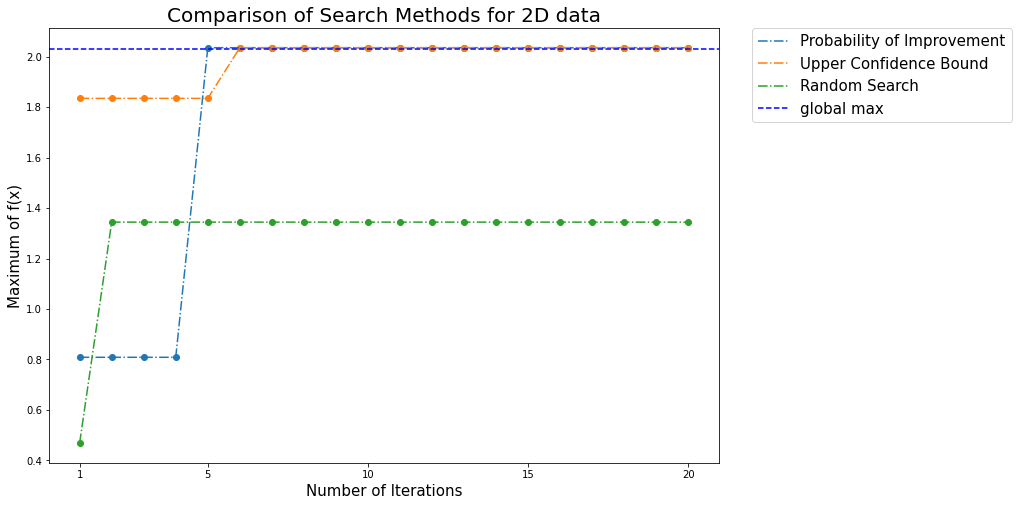

In [16]:
def plot_comparison(max_values_prob_improve, max_values_ucb,max_values_RS):
    iterations = list(range(1, len(max_values_PI) + 1))
    plt.figure(figsize=(12, 8))
    plt.plot(iterations, max_values_PI, label='Probability of Improvement',ls='dashdot')
    plt.scatter(iterations,max_values_PI)
    plt.plot(iterations, max_values_UCB, label='Upper Confidence Bound',ls='dashdot')
    plt.scatter(iterations,max_values_UCB)
    plt.plot(iterations, max_values_RS, label='Random Search',ls='dashdot')
    plt.scatter(iterations,max_values_RS)

    plt.axhline(y=2.03, color='b',label='global max', linestyle='--')
    plt.xticks([1,5,10,15,20])
    plt.xlabel('Number of Iterations',fontsize=15)
    plt.ylabel('Maximum of f(x)',fontsize=15)
    plt.title('Comparison of Search Methods for 2D data',fontsize=20)
#     plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=15, borderaxespad=0.)
    plt.show()

# Plot the comparison
plot_comparison(max_values_PI, max_values_UCB,max_values_RS )